In [1]:
#Importing required libraries
import matplotlib.pyplot as plt
from PIL import Image
# import seaborn as sns
import numpy as np
import pandas as pd
import os
from tensorflow.keras.utils import to_categorical
from glob import glob
# start = time.time()
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
# end=time.time()
# print("The time of execution of above program is :",(end-start) * 10**3, "ms")
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization,Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
import tensorflow as tf
import pickle
import zlib
import pandas as pd
from sklearn.model_selection import train_test_split

/tmp/ipykernel_74590/3786660012.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-03-25 17:42:09.126199: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-25 17:42:09.126231: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-25 17:42:09.127254: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable 

In [2]:
# Reading the data from HAM_metadata.csv
df = pd.read_csv('HAM10000_metadata.csv')
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [3]:
df['age'].fillna(int(df['age'].mean()),inplace=True)

/tmp/ipykernel_74590/2028790963.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['age'].fillna(int(df['age'].mean()),inplace=True)


In [4]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
base_skin_dir = '../input/skin-cancer-mnist-ham10000'
# base_skin_dir=r"C:\Users\Melvin\Downloads\PROJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJ"
base_skin_dir='/home/Melvin/Downloads/PROJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJ'
# Merge images from both folders into one dictionary
# Image.open('/home/Melvin/Downloads/PROJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJ/HAM10000_images_part_1/ISIC_0026279.jpg')

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

len(imageid_path_dict)

25331

In [5]:
df['path'] = df['image_id'].map(imageid_path_dict.get)
df[['path','image_id']].head(5)

,path,image_id
0,/home/Melvin/Downloads/PROJJJJJJJJJJJJJJJJJJJJ...,ISIC_0027419
1,/home/Melvin/Downloads/PROJJJJJJJJJJJJJJJJJJJJ...,ISIC_0025030
2,/home/Melvin/Downloads/PROJJJJJJJJJJJJJJJJJJJJ...,ISIC_0026769
3,/home/Melvin/Downloads/PROJJJJJJJJJJJJJJJJJJJJ...,ISIC_0025661
4,/home/Melvin/Downloads/PROJJJJJJJJJJJJJJJJJJJJ...,ISIC_0031633


In [6]:
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get) 
df['cell_type'].unique()

array(['Benign keratosis-like lesions ', 'Melanocytic nevi',
       'Dermatofibroma', 'Melanoma', 'Vascular lesions',
       'Basal cell carcinoma', 'Actinic keratoses'], dtype=object)

In [7]:
code={'Benign keratosis-like lesions ': [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
     'Melanocytic nevi': [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
      'Dermatofibroma': [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
      'Melanoma': [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
      'Vascular lesions': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
      'Basal cell carcinoma': [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
      'Actinic keratoses':[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
     }
for x in code.keys():
    print(code[x])

[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]


In [8]:
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get) 
# df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes #      id for each cell type 
df['cell_type_idx'] = df['cell_type'].map(code)

In [9]:
df[df['cell_type_idx'].isna()]

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx


In [10]:
df.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
4962,HAM_0002777,ISIC_0030228,nv,follow_up,50.0,female,abdomen,/home/Melvin/Downloads/PROJJJJJJJJJJJJJJJJJJJJ...,Melanocytic nevi,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
289,HAM_0006128,ISIC_0028701,bkl,histo,55.0,female,lower extremity,/home/Melvin/Downloads/PROJJJJJJJJJJJJJJJJJJJJ...,Benign keratosis-like lesions,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
4295,HAM_0006811,ISIC_0024794,nv,follow_up,55.0,female,trunk,/home/Melvin/Downloads/PROJJJJJJJJJJJJJJJJJJJJ...,Melanocytic nevi,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
1644,HAM_0000064,ISIC_0032603,mel,histo,30.0,female,lower extremity,/home/Melvin/Downloads/PROJJJJJJJJJJJJJJJJJJJJ...,Melanoma,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
2440,HAM_0001372,ISIC_0031103,vasc,consensus,35.0,female,trunk,/home/Melvin/Downloads/PROJJJJJJJJJJJJJJJJJJJJ...,Vascular lesions,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"


In [11]:
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,100))))


In [12]:
df= df[df['age'] != 0]
df= df[df['sex'] != 'unknown']
df[df['age'] != 0]

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/home/Melvin/Downloads/PROJJJJJJJJJJJJJJJJJJJJ...,Benign keratosis-like lesions,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]","[[[190, 153, 195], [192, 155, 197], [191, 153,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/home/Melvin/Downloads/PROJJJJJJJJJJJJJJJJJJJJ...,Benign keratosis-like lesions,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]","[[[24, 13, 22], [24, 14, 24], [25, 14, 28], [3..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/home/Melvin/Downloads/PROJJJJJJJJJJJJJJJJJJJJ...,Benign keratosis-like lesions,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]","[[[186, 128, 137], [190, 134, 148], [194, 137,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/home/Melvin/Downloads/PROJJJJJJJJJJJJJJJJJJJJ...,Benign keratosis-like lesions,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]","[[[24, 11, 17], [25, 12, 22], [36, 21, 30], [5..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/home/Melvin/Downloads/PROJJJJJJJJJJJJJJJJJJJJ...,Benign keratosis-like lesions,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]","[[[132, 89, 112], [146, 101, 124], [158, 114, ..."
...,...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,/home/Melvin/Downloads/PROJJJJJJJJJJJJJJJJJJJJ...,Actinic keratoses,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[[[143, 125, 133], [141, 122, 131], [137, 119,..."
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,/home/Melvin/Downloads/PROJJJJJJJJJJJJJJJJJJJJ...,Actinic keratoses,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[[[5, 6, 3], [6, 7, 4], [7, 8, 6], [8, 7, 5], ..."
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,/home/Melvin/Downloads/PROJJJJJJJJJJJJJJJJJJJJ...,Actinic keratoses,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[[[110, 101, 103], [126, 115, 115], [139, 125,..."
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,/home/Melvin/Downloads/PROJJJJJJJJJJJJJJJJJJJJ...,Actinic keratoses,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[[[158, 121, 144], [159, 122, 140], [153, 110,..."


In [13]:
df.reset_index(drop=True, inplace=True)


(array([109., 663.,   0.,  12.,   0., 112.,  14.,   0.,  52.,  33.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

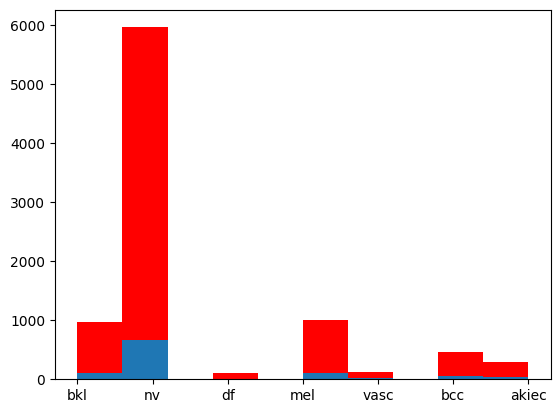

In [14]:
train_size = 0.9  # 90% for training, 10% for testing

# Find unique classes in the dataset
classes = df['dx'].unique()

# Initialize lists to store indices for train and test data
train_indices = []
test_indices = []

# Split the data for each class
for cls in classes:
    # Find indices of samples belonging to the current class
    indices = df.index[df['dx'] == cls].tolist()
    
    # Split the indices into train and test
    train_idx, test_idx = train_test_split(indices, train_size=train_size, random_state=42)
    
    # Add the indices to the respective lists
    train_indices.extend(train_idx)
    test_indices.extend(test_idx)

# Use the indices to split the data
train_data = df.iloc[train_indices]
test_data = df.iloc[test_indices]
plt.hist(train_data['dx'],color='red')
plt.hist(test_data['dx'])

(array([ 98., 597.,   0.,  11.,   0., 101.,  13.,   0.,  47.,  30.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

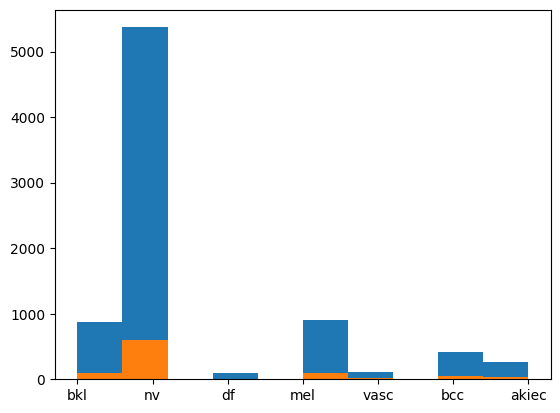

In [15]:
train_data.reset_index(drop=True, inplace=True)

train_size = 0.9  # 90% for training, 10% for testing

# Find unique classes in the dataset
classes = train_data['dx'].unique()

# Initialize lists to store indices for train and test data
train_indices = []
validate_indices = []

# Split the data for each class
for cls in classes:
    # Find indices of samples belonging to the current class
    indices = train_data.index[train_data['dx'] == cls].tolist()
    
    # Split the indices into train and test
    train_idx, validate_inx = train_test_split(indices, train_size=train_size, random_state=42)
    
    # Add the indices to the respective lists
    train_indices.extend(train_idx)
    validate_indices.extend(validate_inx)
# Use the indices to split the data
validate_data = train_data.iloc[validate_indices]
train_data_temp = train_data.iloc[train_indices]

train_data=train_data_temp
plt.hist(train_data['dx'])
plt.hist(validate_data['dx'])

In [16]:
test_data.shape

(995, 11)

In [17]:
x_train=train_data.drop(columns=['cell_type_idx'],axis=1)
y_train=train_data['cell_type_idx']
x_validate=validate_data.drop(columns=['cell_type_idx'],axis=1)
y_validate=validate_data['cell_type_idx']
x_test=test_data.drop(columns=['cell_type_idx'],axis=1)
y_test=test_data['cell_type_idx']

In [18]:
x_train=x_train['image']
x_test=x_test['image']
x_validate=x_validate['image']

In [19]:
x_train=x_train/255
x_validate=x_validate/255
x_test=x_test/255

In [20]:
import gc
gc.collect()

40

In [21]:
x_train=tf.convert_to_tensor(x_train.tolist(), dtype=tf.float32)

2024-03-25 17:47:03.296926: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-25 17:47:03.518487: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-25 17:47:03.518996: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [22]:
x_validate=tf.convert_to_tensor(x_validate.tolist(),dtype=tf.float32)

In [23]:
x_test=tf.convert_to_tensor(x_test.tolist(), dtype=tf.float32)

In [24]:
y_train=tf.convert_to_tensor(y_train.tolist(), dtype=tf.float32)

In [25]:
y_test=tf.convert_to_tensor(y_test.tolist(), dtype=tf.float32)

In [26]:
y_validate=tf.convert_to_tensor(y_validate.tolist(), dtype=tf.float32)

In [27]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.12,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.12,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images
datagen.fit(x_train)
# Image.open(datagen.flow(x_train[0]))

2024-03-25 17:49:28.067278: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 963480000 exceeds 10% of free system memory.


In [30]:
from keras.models import load_model

# Load the pre-trained ResNet50 model
# model = load_model('resnet50model_trainable.h5')

# Now you can use the loaded model for further operations
# For example:
# model.predict(data)

resnet50model = load_model("resnet50model__trainable.h5")
inception = tf.keras.saving.load_model("inception_trainable.h5")
efficient = tf.keras.saving.load_model("efficient_trainable.h5")
vgg = tf.keras.saving.load_model("vgg_trainable.h5")



In [32]:
# y_test.shape

dd={
0:[1., 0., 0., 0., 0., 0., 0., 0.],
1:[0., 1., 0., 0., 0., 0., 0., 0.],
2:[0., 0., 1., 0., 0., 0., 0., 0.],
3:[0., 0., 0., 1., 0., 0., 0., 0.],
4:[0., 0., 0., 0., 1., 0., 0., 0.],
5:[0., 0., 0., 0., 0., 1., 0., 0.],
6:[0., 0., 0., 0., 0., 0., 1., 0.],
7:[0., 0., 0., 0., 0., 0., 0., 1.],

}
labels={0:'Actinic keratoses',
       1:'Basal cell carcinoma',
       2:'Benign keratosis-like lesions',
       3:'Dermatofibroma',
       4:'Melanocytic nevi',
       5:'Melanoma',
       6:'Vascular lesions',
       }
class_labels=['Actinic keratoses',
       'Basal cell carcinoma',
       'Benign keratosis-like lesions',
       'Dermatofibroma',
       'Melanocytic nevi',
       'Melanoma',
       'Vascular lesions']
# y_p=y_p.map(dd)
# y_p


2024-03-25 17:53:16.534734: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


32/32 [==============================] - 8s 41ms/step
0.9628140703517588
Precision: 0.8562405167042809
Recall: 0.77746546126791
F1 Score: 0.8019828095707773
Confusion Matrix:
[[107   3   0   0   2   0   0   0]
 [  2 656   1   0   4   0   0   0]
 [  1   0  50   0   1   0   0   0]
 [  0   0   0  14   2   0   0  17]
 [  1   2   0   0 106   0   0   0]
 [  1   0   0   0   0  11   0   0]
 [  0   0   0   0   0   0  14   0]
 [  0   0   0   0   0   0   0   0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       112
           1       0.99      0.99      0.99       663
           2       0.98      0.96      0.97        52
           3       1.00      0.42      0.60        33
           4       0.92      0.97      0.95       109
           5       1.00      0.92      0.96        12
           6       1.00      1.00      1.00        14
           7       0.00      0.00      0.00         0

    accuracy                     

/home/Melvin/anaconda3/envs/ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/Melvin/anaconda3/envs/ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/Melvin/anaconda3/envs/ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/Melvin/ana

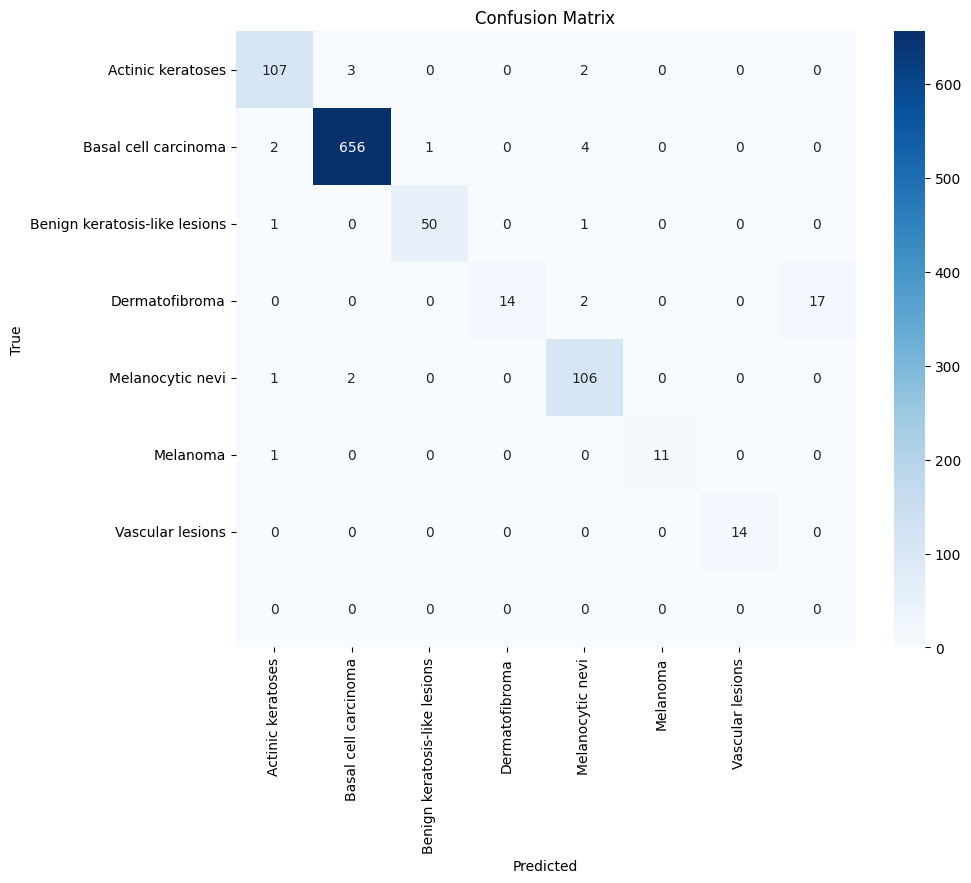

In [33]:
from sklearn.metrics import accuracy_score
l=[]
y_p=resnet50model.predict(x_test)
y_p=np.argmax(y_p, axis=1)
l=[]
for x in y_p:
    l.append(dd[x])
l
# y_p=y_p.map(dd)
print(accuracy_score(y_test,l))
from sklearn.metrics import precision_score
import seaborn as sns
y_t_classes=y_test
y_p_classes=l

precision = precision_score(y_t_classes, y_p_classes, average='macro')  # Use 'macro' for multi-class classification
print("Precision:", precision)

from sklearn.metrics import recall_score

recall = recall_score(y_t_classes, y_p_classes, average='macro')  # Use 'macro' for multi-class classification
print("Recall:", recall)


from sklearn.metrics import f1_score

f1 = f1_score(y_t_classes, y_p_classes, average='macro')  # Use 'macro' for multi-class classification
print("F1 Score:", f1)


from sklearn.metrics import confusion_matrix
y_p_classes = np.argmax(l, axis=1)
y_t_classes=np.argmax(y_test, axis=1)
cm = confusion_matrix(y_t_classes, y_p_classes)
print("Confusion Matrix:")
print(cm)


from sklearn.metrics import classification_report

report = classification_report(y_t_classes, y_p_classes)
print("Classification Report:")
print(report)


cm = confusion_matrix(y_t_classes, y_p_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


32/32 [==============================] - 4s 47ms/step
0.9477386934673366
Precision: 0.8238619788619789
Recall: 0.7827622632584181
F1 Score: 0.7948304295847348
Confusion Matrix:
[[102   5   0   1   3   0   0   1]
 [  8 648   1   0   5   0   1   0]
 [  0   2  48   0   1   0   1   0]
 [  0   0   0  17   1   0   0  15]
 [  1   5   1   0 102   0   0   0]
 [  0   0   0   0   0  12   0   0]
 [  0   0   0   0   0   0  14   0]
 [  0   0   0   0   0   0   0   0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.91       112
           1       0.98      0.98      0.98       663
           2       0.96      0.92      0.94        52
           3       0.94      0.52      0.67        33
           4       0.91      0.94      0.92       109
           5       1.00      1.00      1.00        12
           6       0.88      1.00      0.93        14
           7       0.00      0.00      0.00         0

    accuracy                   

/home/Melvin/anaconda3/envs/ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/Melvin/anaconda3/envs/ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/Melvin/anaconda3/envs/ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/Melvin/ana

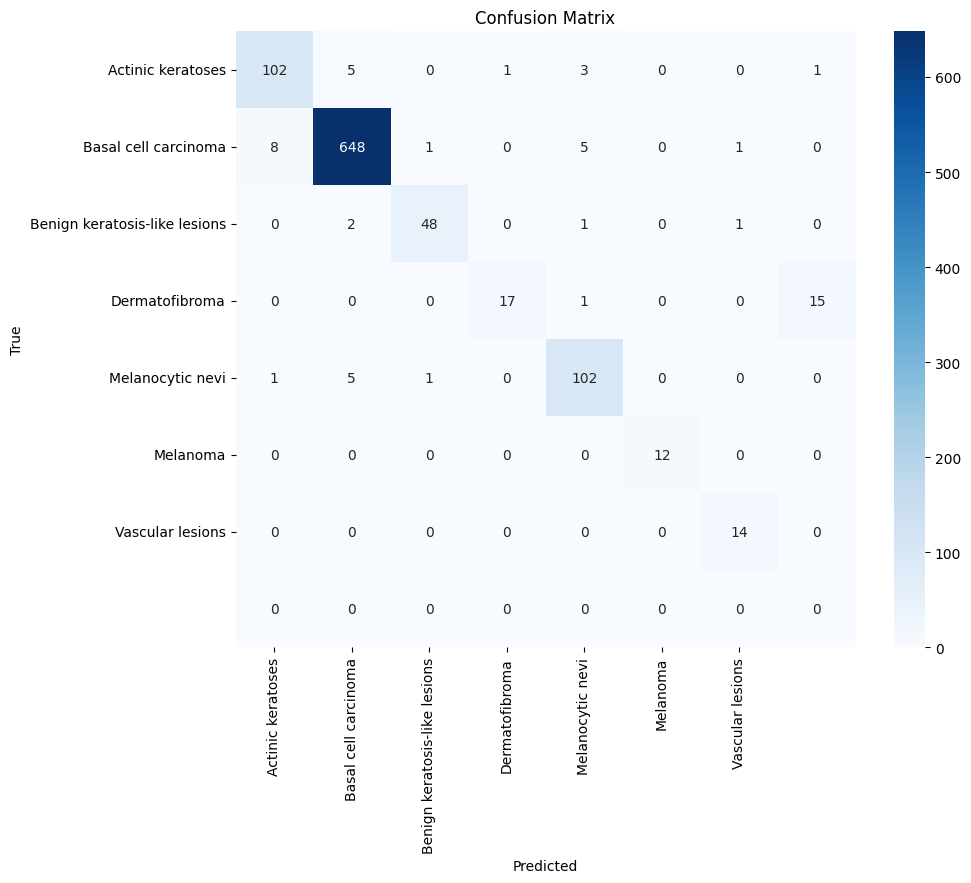

In [34]:
y_p=inception.predict(x_test)
y_p=np.argmax(y_p, axis=1)
l=[]
for x in y_p:
    l.append(dd[x])
l
# y_p=y_p.map(dd)
print(accuracy_score(y_test,l))
from sklearn.metrics import precision_score
y_t_classes=y_test
y_p_classes=l

precision = precision_score(y_t_classes, y_p_classes, average='macro')  # Use 'macro' for multi-class classification
print("Precision:", precision)

from sklearn.metrics import recall_score

recall = recall_score(y_t_classes, y_p_classes, average='macro')  # Use 'macro' for multi-class classification
print("Recall:", recall)


from sklearn.metrics import f1_score

f1 = f1_score(y_t_classes, y_p_classes, average='macro')  # Use 'macro' for multi-class classification
print("F1 Score:", f1)


from sklearn.metrics import confusion_matrix
y_p_classes = np.argmax(l, axis=1)
y_t_classes=np.argmax(y_test, axis=1)
cm = confusion_matrix(y_t_classes, y_p_classes)
print("Confusion Matrix:")
print(cm)


from sklearn.metrics import classification_report

report = classification_report(y_t_classes, y_p_classes)
print("Classification Report:")
print(report)

cm = confusion_matrix(y_t_classes, y_p_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


32/32 [==============================] - 4s 37ms/step
0.6492462311557788
Precision: 0.12045826843546914
Recall: 0.15240350948071538
F1 Score: 0.13446127292809285
Confusion Matrix:
[[ 33  79   0   0   0   0   0]
 [ 50 613   0   0   0   0   0]
 [ 10  42   0   0   0   0   0]
 [  9  24   0   0   0   0   0]
 [ 23  86   0   0   0   0   0]
 [  4   8   0   0   0   0   0]
 [  0  14   0   0   0   0   0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.26      0.29      0.27       112
           1       0.71      0.92      0.80       663
           2       0.00      0.00      0.00        52
           3       0.00      0.00      0.00        33
           4       0.00      0.00      0.00       109
           5       0.00      0.00      0.00        12
           6       0.00      0.00      0.00        14

    accuracy                           0.65       995
   macro avg       0.14      0.17      0.15       995
weighted avg       0.50      0.65    

/home/Melvin/anaconda3/envs/ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/Melvin/anaconda3/envs/ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/Melvin/anaconda3/envs/ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(re

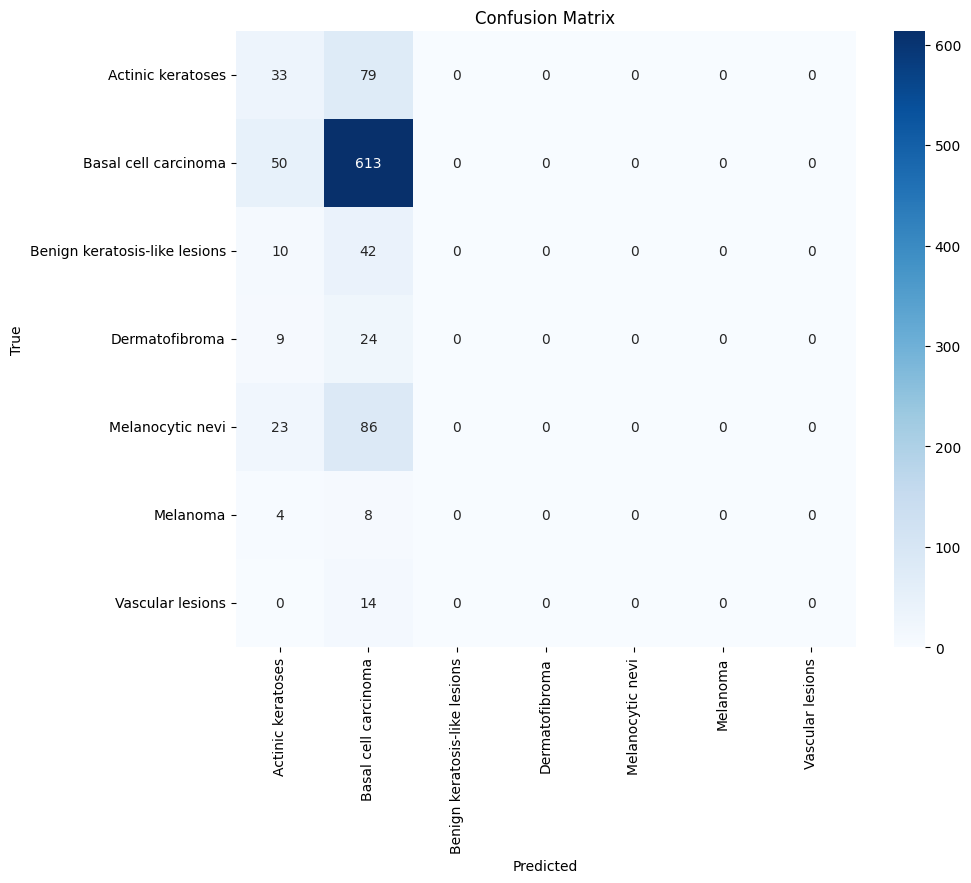

In [35]:
y_p=efficient.predict(x_test)
y_p=np.argmax(y_p, axis=1)
l=[]
for x in y_p:
    l.append(dd[x])
l
# y_p=y_p.map(dd)
print(accuracy_score(y_test,l))
from sklearn.metrics import precision_score
y_t_classes=y_test
y_p_classes=l

precision = precision_score(y_t_classes, y_p_classes, average='macro')  # Use 'macro' for multi-class classification
print("Precision:", precision)

from sklearn.metrics import recall_score

recall = recall_score(y_t_classes, y_p_classes, average='macro')  # Use 'macro' for multi-class classification
print("Recall:", recall)


from sklearn.metrics import f1_score

f1 = f1_score(y_t_classes, y_p_classes, average='macro')  # Use 'macro' for multi-class classification
print("F1 Score:", f1)


from sklearn.metrics import confusion_matrix
y_p_classes = np.argmax(l, axis=1)
y_t_classes=np.argmax(y_test, axis=1)
cm = confusion_matrix(y_t_classes, y_p_classes)
print("Confusion Matrix:")
print(cm)


from sklearn.metrics import classification_report

report = classification_report(y_t_classes, y_p_classes)
print("Classification Report:")
print(report)

cm = confusion_matrix(y_t_classes, y_p_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


32/32 [==============================] - 2s 32ms/step
0.9376884422110553
Precision: 0.8308507288731168
Recall: 0.761424685395105
F1 Score: 0.7792772084927511
Confusion Matrix:
[[107   4   0   0   1   0   0   0]
 [ 19 642   0   0   1   0   1   0]
 [  4   1  42   0   5   0   0   0]
 [  0   0   0  14   1   0   0  18]
 [  4   3   0   0 102   0   0   0]
 [  0   0   0   0   0  12   0   0]
 [  0   0   0   0   0   0  14   0]
 [  0   0   0   0   0   0   0   0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.96      0.87       112
           1       0.99      0.97      0.98       663
           2       1.00      0.81      0.89        52
           3       1.00      0.42      0.60        33
           4       0.93      0.94      0.93       109
           5       1.00      1.00      1.00        12
           6       0.93      1.00      0.97        14
           7       0.00      0.00      0.00         0

    accuracy                    

/home/Melvin/anaconda3/envs/ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/Melvin/anaconda3/envs/ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/Melvin/anaconda3/envs/ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/Melvin/ana

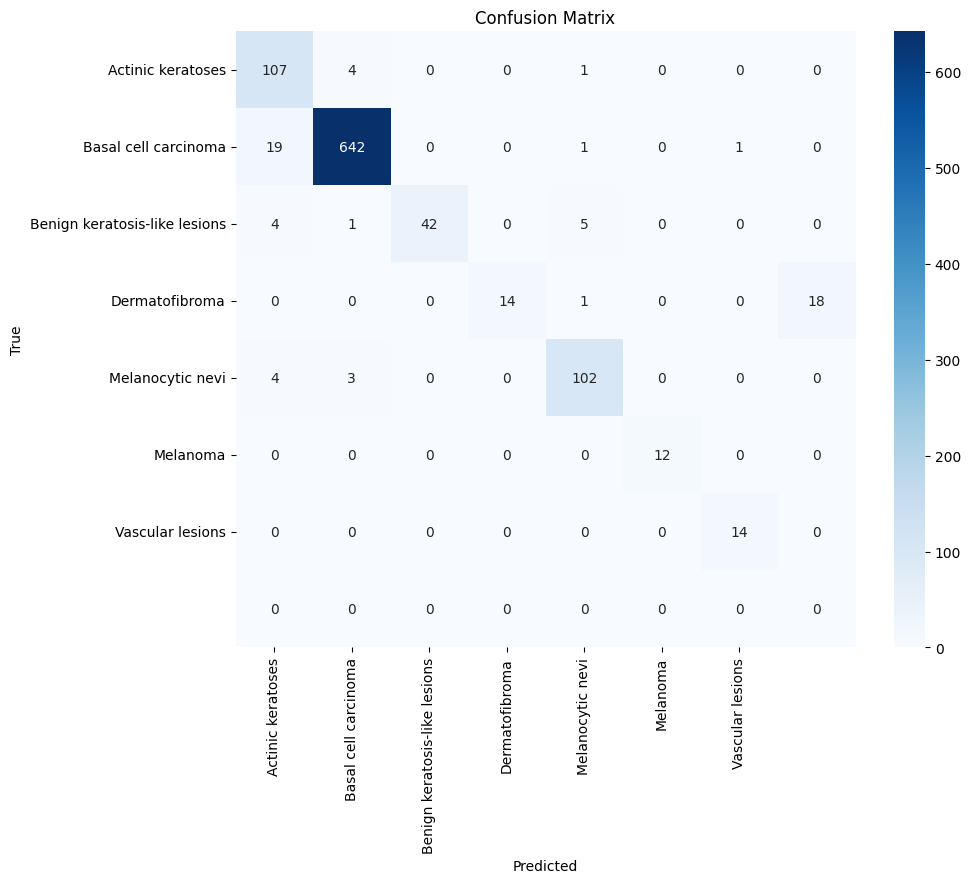

In [36]:
y_p=vgg.predict(x_test)
y_p=np.argmax(y_p, axis=1)
l=[]
for x in y_p:
    l.append(dd[x])
l
# y_p=y_p.map(dd)
print(accuracy_score(y_test,l))
from sklearn.metrics import precision_score
y_t_classes=y_test
y_p_classes=l

precision = precision_score(y_t_classes, y_p_classes, average='macro')  # Use 'macro' for multi-class classification
print("Precision:", precision)

from sklearn.metrics import recall_score

recall = recall_score(y_t_classes, y_p_classes, average='macro')  # Use 'macro' for multi-class classification
print("Recall:", recall)


from sklearn.metrics import f1_score

f1 = f1_score(y_t_classes, y_p_classes, average='macro')  # Use 'macro' for multi-class classification
print("F1 Score:", f1)


from sklearn.metrics import confusion_matrix
y_p_classes = np.argmax(l, axis=1)
y_t_classes=np.argmax(y_test, axis=1)
cm = confusion_matrix(y_t_classes, y_p_classes)
print("Confusion Matrix:")
print(cm)


from sklearn.metrics import classification_report

report = classification_report(y_t_classes, y_p_classes)
print("Classification Report:")
print(report)

cm = confusion_matrix(y_t_classes, y_p_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


29/29 [==============================] - 0s 15ms/step
Epoch 1/100
251/251 [==============================] - 1s 3ms/step - loss: 0.7054 - accuracy: 0.8123 - val_loss: 0.3454 - val_accuracy: 0.8785
Epoch 2/100
251/251 [==============================] - 1s 2ms/step - loss: 0.2695 - accuracy: 0.9154 - val_loss: 0.2247 - val_accuracy: 0.9309
Epoch 3/100
251/251 [==============================] - 1s 2ms/step - loss: 0.1889 - accuracy: 0.9595 - val_loss: 0.1741 - val_accuracy: 0.9554
Epoch 4/100
251/251 [==============================] - 1s 2ms/step - loss: 0.1474 - accuracy: 0.9717 - val_loss: 0.1447 - val_accuracy: 0.9610
Epoch 5/100
251/251 [==============================] - 1s 2ms/step - loss: 0.1211 - accuracy: 0.9765 - val_loss: 0.1248 - val_accuracy: 0.9755
Epoch 6/100
251/251 [==============================] - 1s 2ms/step - loss: 0.1030 - accuracy: 0.9856 - val_loss: 0.1110 - val_accuracy: 0.9777
Epoch 7/100
251/251 [==============================] - 1s 2ms/step - loss: 0.0904 - accu

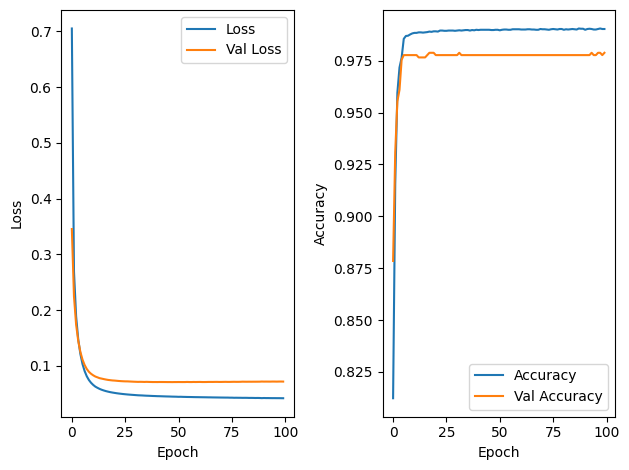

32/32 [==============================] - 0s 956us/step
Accuracy:  0.9939698492462311


/home/Melvin/anaconda3/envs/ml/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [39]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import ResNet50, InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import SGD


class multimodel:
    resnet50model=None
    inceptionmodel=None
    efficientnetmodel=None
    vggmodel=None
    model=None
    history=None
   
    def __init__(self):
        self.resnet50model=resnet50model
        self.inceptionmodel=inception
        self.efficientnetmodel=efficient
        self.vggmodel=vgg
        
        self.model=tf.keras.Sequential([
        Dense(100,input_shape=(None,32)),
        Dense(50, activation='relu'),
        Dense(8, activation='softmax')
        ])
        self.model.compile('sgd', loss='categorical_crossentropy', metrics=['accuracy'])
        # self.history={
        #      'loss': [],
        #      'accuracy': [],
        #      'val_loss': [],
        #      'val_accuracy': []
        # }

    def fit(self,x,y,x_v,y_v,epoch):
        r_p=self.resnet50model.predict(x)
        r_v=self.resnet50model.predict(x_v)

        e_p=self.efficientnetmodel.predict(x)
        e_v=self.efficientnetmodel.predict(x_v)

        v_p=self.vggmodel.predict(x)
        v_v=self.vggmodel.predict(x_v)
        
        i_p=self.inceptionmodel.predict(x)
        i_v=self.resnet50model.predict(x_v)
        inp=np.concatenate((r_p, i_p), axis=1)
        inp=np.concatenate((inp, e_p), axis=1)
        inp=np.concatenate((inp, v_p), axis=1)

        
        inp_v=np.concatenate((r_v, i_v), axis=1)
        inp_v=np.concatenate((inp_v, e_v), axis=1)
        inp_v=np.concatenate((inp_v, v_v), axis=1)
        
        # inp=np.array(r_p).append(np.array(i_p))
        # inp_v=np.array(r_v).append(np.array(i_v))
        # print('shape of input: ',inp.shape)
        # for x in epoch:
        self.history=self.model.fit(inp,y, batch_size=32,validation_data=(inp_v,y_v),epochs=epoch)
            # self.history['loss'].append(temp_history['loss'])
            # self.history['accuracy'].append(temp_history['accuracy'])
            # self.history['val_loss'].append(temp_history['val_loss'])
            # self.history['val_accuracy'].append(temp_history['val_accuracy'])

    # def fit_sample(self,x,y):
    #     r_p=self.resnet50model.predict(x)
    #     # r_v=self.resnet50model.predict(x,y)
    #     i_p=self.inceptionmodel.predict(x)
    #     # i_v=self.resnet50model.predict(x_v,y_v)
    #     inp=np.concatenate((r_p, i_p), axis=1)
    #     inp=tf.convert_to_tensor(inp, dtype=tf.float32)
    #     # inp_v=np.array(r_v).append(np.array(i_v))
    #     self.history=self.model.fit(inp,y, epochs=10)
    
    def predict(self,x):
        r_p=self.resnet50model.predict(x)
        i_p=self.inceptionmodel.predict(x)
        v_p=self.vggmodel.predict(x)
        e_p=self.efficientnetmodel.predict(x)
        inp=np.concatenate((r_p, i_p), axis=1)
        inp=np.concatenate((inp, e_p), axis=1)
        inp=np.concatenate((inp, v_p), axis=1)
        
        return self.model.predict(inp)
        
        
        
    def plot(self):
        plt.subplot(1,2,1)
        plt.plot(self.history.history['loss'],label='Loss')
        plt.plot(self.history.history['val_loss'],label='Val Loss')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        
        plt.subplot(1,2,2)
        plt.plot(self.history.history['accuracy'],label='Accuracy')
        plt.plot(self.history.history['val_accuracy'],label='Val Accuracy')
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.tight_layout()  # Adjust subplots to prevent overlap
        plt.show()
    
    def save(self,path):
        self.model.save(path)
        

        
combined_model=multimodel()
combined_model.fit(x_train,y_train,x_validate,y_validate,100)
combined_model.plot()
predicted=combined_model.predict(x_test)
predicted=np.argmax(predicted, axis=1)
l=[]
for x in predicted:
    l.append(dd[x])
l
# y_p=y_p.map(dd)
print("Accuracy: ",accuracy_score(y_test,l))
combined_model.save('the_4_final.h5')
with open('final_model_history.pkl','wb') as f:
    pickle.dump(combined_model.history,f)
# predicted

In [40]:
combined_model.model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, None, 100)         3300      
                                                                 
 dense_4 (Dense)             (None, None, 50)          5050      
                                                                 
 dense_5 (Dense)             (None, None, 8)           408       
                                                                 
Total params: 8758 (34.21 KB)
Trainable params: 8758 (34.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


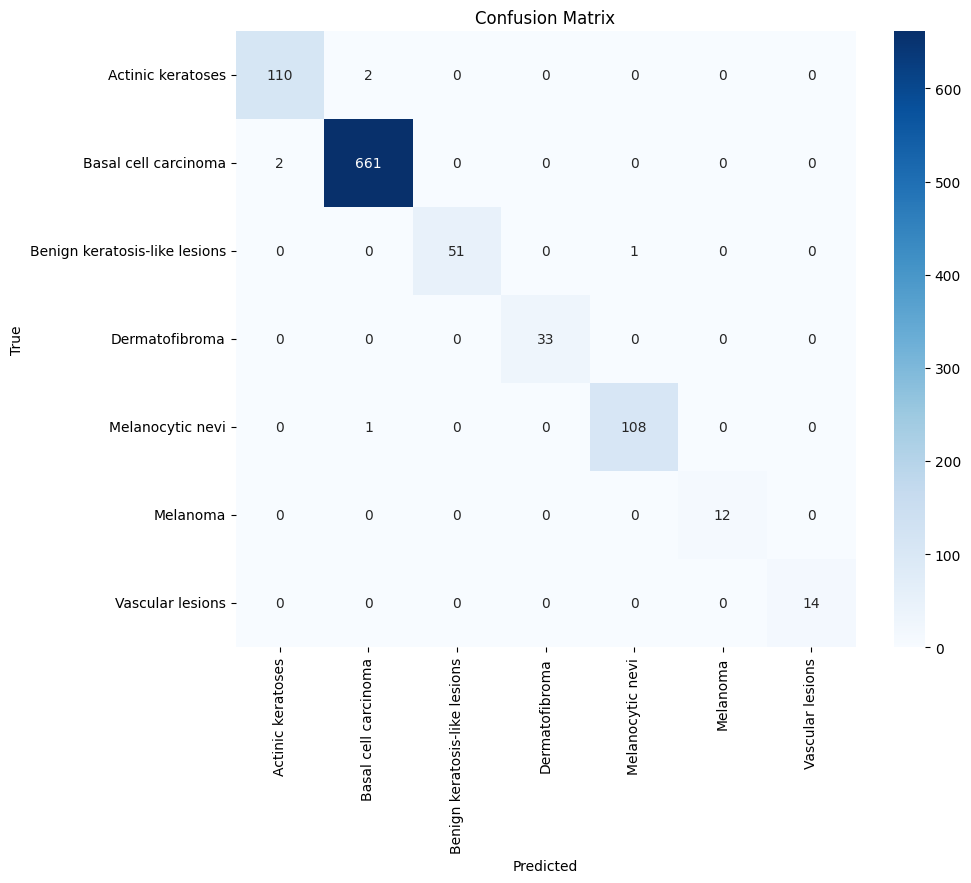

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_test and y_p are one-dimensional arrays of class labels
# If y_p is probabilities, convert it to class labels first
# If y_test and y_p are one-hot encoded, convert them to class labels using np.argmax()

# Compute confusion matrix
y_p_classes = np.argmax(l, axis=1)
y_t_classes=np.argmax(y_test, axis=1)

cm = confusion_matrix(y_t_classes, y_p_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [51]:
print("Final Accuracy:",accuracy_score(y_t_classes,y_p_classes))


Final Accuracy: 0.9939698492462311


In [42]:
from sklearn.metrics import precision_score

precision = precision_score(y_t_classes, y_p_classes, average='macro')  # Use 'macro' for multi-class classification
print("Precision:", precision)

Precision: 0.9954929247038707


In [43]:
from sklearn.metrics import recall_score

recall = recall_score(y_t_classes, y_p_classes, average='macro')  # Use 'macro' for multi-class classification
print("Recall:", recall)


Recall: 0.9929601692476567


In [44]:
from sklearn.metrics import f1_score

f1 = f1_score(y_t_classes, y_p_classes, average='macro')  # Use 'macro' for multi-class classification
print("F1 Score:", f1)


F1 Score: 0.9942131299769981


In [45]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_t_classes, y_p_classes)
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[110   2   0   0   0   0   0]
 [  2 661   0   0   0   0   0]
 [  0   0  51   0   1   0   0]
 [  0   0   0  33   0   0   0]
 [  0   1   0   0 108   0   0]
 [  0   0   0   0   0  12   0]
 [  0   0   0   0   0   0  14]]


In [46]:
from sklearn.metrics import classification_report

report = classification_report(y_t_classes, y_p_classes)
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       112
           1       1.00      1.00      1.00       663
           2       1.00      0.98      0.99        52
           3       1.00      1.00      1.00        33
           4       0.99      0.99      0.99       109
           5       1.00      1.00      1.00        12
           6       1.00      1.00      1.00        14

    accuracy                           0.99       995
   macro avg       1.00      0.99      0.99       995
weighted avg       0.99      0.99      0.99       995

